In [1]:
import os
import music21 as m21

Loaded 12 songs.


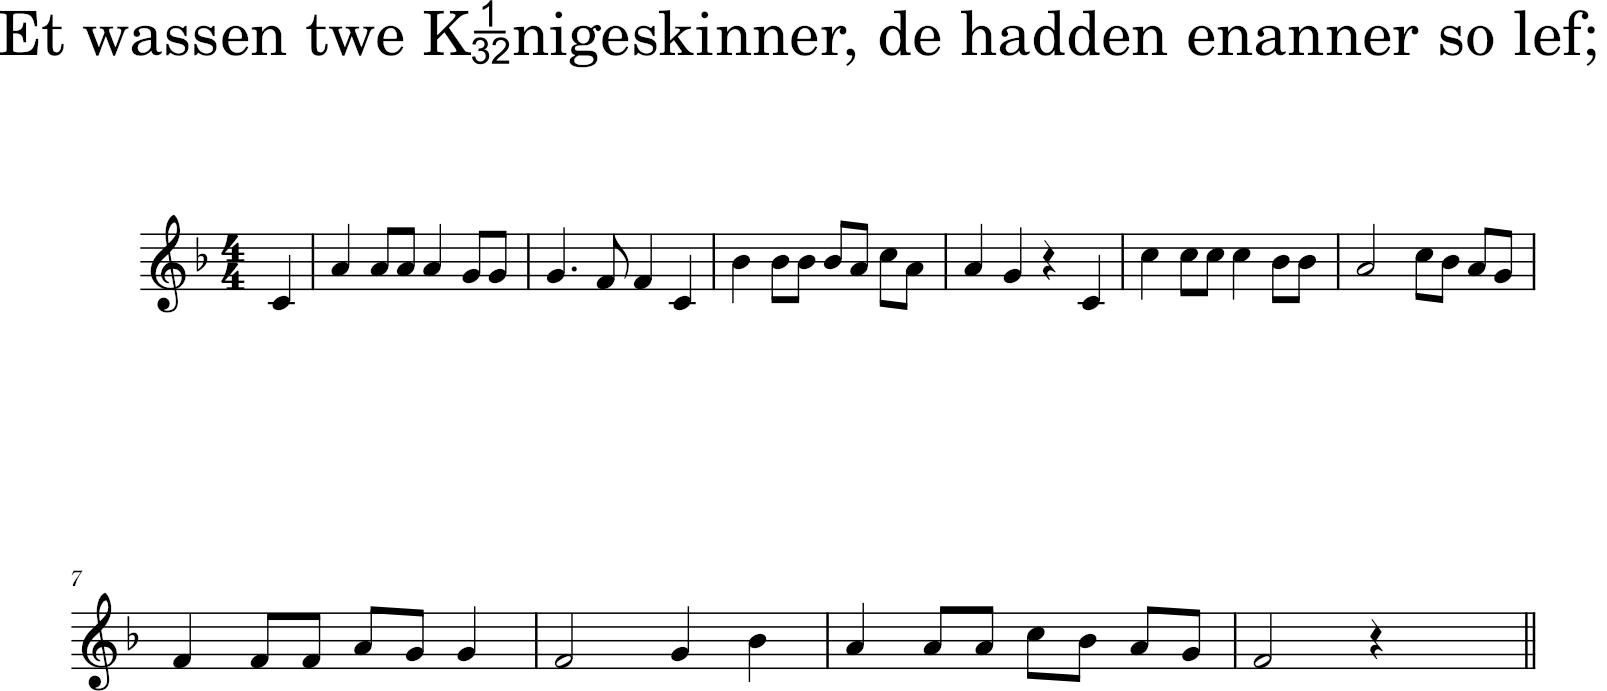

In [ ]:
#m21.environment.set('musicxmlPath', 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe') 
env = m21.environment.Environment()
env['musescoreDirectPNGPath'] = r'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
env['musicxmlPath'] = r'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'

# Create constant
KERN_DATASET_PATH = "deutschl/test"

# Load all songs from the data set
def load_songs_in_kern(dataset_path):
    songs = []
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:
            if file[-3:] == "krn":
                song=m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

def preprocess(dataset_path):
    pass

    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs.")

if __name__ == "__main__":
    songs = load_songs_in_kern(KERN_DATASET_PATH)
    print(f"Loaded {len(songs)} songs.")
    song = songs[2]
    song.show()